<a href="https://colab.research.google.com/github/ritwiks9635/Segmentation-Model/blob/main/OCT_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**OCT Image Segmentation**

In [ ]:
#https://www.kaggle.com/datasets/paultimothymooney/chiu-2015

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/paultimothymooney/chiu-2015/chiu-2015.zip

In [ ]:
import scipy.io
from scipy.io import loadmat
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.transform import resize

# Visualize the Data

In [ ]:
input_path = "/content/2015_boe_chiu/2015_BOE_Chiu"

subject_path = sorted([os.path.join(input_path, f) for f in os.listdir(input_path)])
print(subject_path)

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

['/content/2015_boe_chiu/2015_BOE_Chiu/Subject_01.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_02.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_03.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_04.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_05.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_06.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_07.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_08.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_09.mat', '/content/2015_boe_chiu/2015_BOE_Chiu/Subject_10.mat']


In [ ]:
mat = loadmat(subject_path[0])

img_tensor = mat["images"]

manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

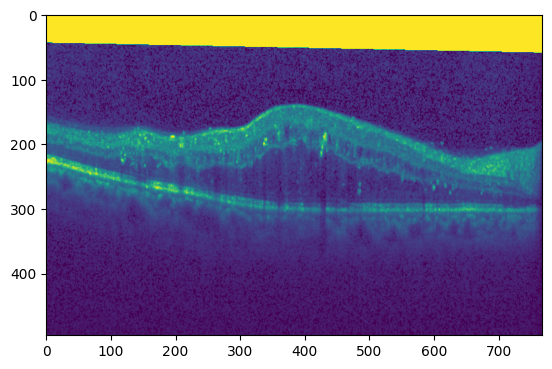

In [ ]:
plt.imshow(img_array[25])

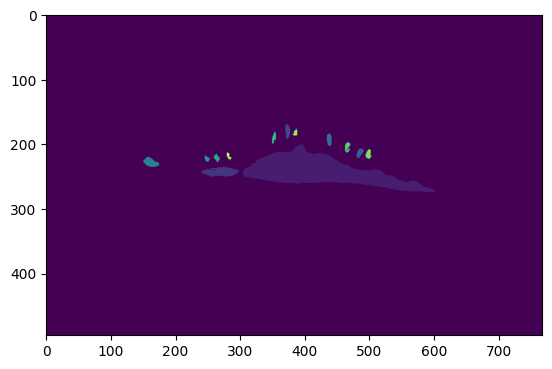

In [ ]:
plt.imshow(manual_fluid_array[25])

# Prepare Dataset

In [ ]:
def thresh(x):
    if x == 0:
        return 0
    else:
        return 1

thresh = np.vectorize(thresh, otypes = [float])

def create_dataset(data_path):
    x_data = []
    y_data = []

    for path in tqdm(data_path):
        mat = loadmat(path)
        img_tensor = mat["images"]
        fluid_tensor_1 = mat['manualFluid1']

        img_array = np.transpose(img_tensor, (2, 0, 1)) / 255.0
        fluid_array = np.transpose(fluid_tensor_1, (2, 0, 1))

        img_array = resize(img_array, (img_array.shape[0], width, height))

        fluid_array = thresh(fluid_array)
        fluid_array = resize(fluid_array, (fluid_array.shape[0], width_out, height_out))

        for idx in data_indexes:
            x_data += [np.expand_dims(img_array[idx], 0)]
            y_data += [np.expand_dims(fluid_array[idx], 0)]

    return np.array(x_data), np.array(y_data)

x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

100%|██████████| 1/1 [00:07<00:00,  7.92s/it]


In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(99, 1, 284, 284) (99, 1, 196, 196)
(11, 1, 284, 284) (11, 1, 196, 196)


# Build Model

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import trange
from time import sleep

use_gpu = torch.cuda.is_available()

In [ ]:
batch_size = 9
epochs = 1000
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [ ]:
class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
            return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()
        #Encode
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
                            )
        # Decode
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)

    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)

    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)
        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)
        # Decode
        ##print(x.shape, encode_block1.shape, encode_block2.shape, encode_block3.shape, bottleneck1.shape)
        ##print('Decode Block 3')
        ##print(bottleneck1.shape, encode_block3.shape)
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        ##print(decode_block3.shape)
        ##print('Decode Block 2')
        cat_layer2 = self.conv_decode3(decode_block3)
        ##print(cat_layer2.shape, encode_block2.shape)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        ##print(cat_layer1.shape, encode_block1.shape)
        ##print('Final Layer')
        ##print(cat_layer1.shape, encode_block1.shape)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        ##print(decode_block1.shape)
        final_layer = self.final_layer(decode_block1)
        ##print(final_layer.shape)
        return  final_layer

In [ ]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows)
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes)
    outputs = outputs.resize(batch_size*width_out*height_out, 2)
    labels = labels.resize(batch_size*width_out*height_out)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
learning_rate = 0.01
unet = UNet(in_channel = 1,out_channel = 2)
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(unet.parameters(), lr = 0.01, momentum=0.99)

In [ ]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape =(batch_size, n_classes, img_cols, img_rows)
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape =(batch_size, img_cols, img_rows, n_classes)
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [ ]:
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in t:
    total_loss = 0
    for i in range(epoch_iter):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x , batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : {total_loss / epoch_iter} and validation loss : {val_loss}")

  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
  5%|▌         | 50/1000 [03:38<1:15:24,  4.76s/it]

Total loss in epoch 50 : 0.6660926938056946 and validation loss : 0.5213663578033447


 10%|█         | 100/1000 [07:27<1:11:10,  4.75s/it]

Total loss in epoch 100 : 0.6222012639045715 and validation loss : 0.5748471021652222


 15%|█▌        | 150/1000 [11:15<1:07:09,  4.74s/it]

Total loss in epoch 150 : 0.35849618911743164 and validation loss : 0.3357377350330353


 20%|██        | 200/1000 [15:04<1:03:16,  4.75s/it]

Total loss in epoch 200 : 0.2691597044467926 and validation loss : 0.2490655928850174


 25%|██▌       | 250/1000 [18:53<59:15,  4.74s/it]

Total loss in epoch 250 : 0.25614622235298157 and validation loss : 0.2422686666250229


 30%|███       | 300/1000 [22:41<55:19,  4.74s/it]

Total loss in epoch 300 : 0.25496000051498413 and validation loss : 0.23741024732589722


 35%|███▌      | 350/1000 [26:30<51:29,  4.75s/it]

Total loss in epoch 350 : 0.24793152511119843 and validation loss : 0.26249533891677856


 40%|████      | 400/1000 [30:18<47:25,  4.74s/it]

Total loss in epoch 400 : 0.24883294105529785 and validation loss : 0.24635182321071625


 45%|████▌     | 450/1000 [34:07<43:30,  4.75s/it]

Total loss in epoch 450 : 0.2471681386232376 and validation loss : 0.26330024003982544


 50%|█████     | 500/1000 [37:56<39:30,  4.74s/it]

Total loss in epoch 500 : 0.2483818382024765 and validation loss : 0.295243501663208


 55%|█████▌    | 550/1000 [41:44<35:33,  4.74s/it]

Total loss in epoch 550 : 0.23694385588169098 and validation loss : 0.32198724150657654


 60%|██████    | 600/1000 [45:33<31:38,  4.75s/it]

Total loss in epoch 600 : 0.2366272360086441 and validation loss : 0.29055655002593994


 65%|██████▌   | 650/1000 [49:21<27:42,  4.75s/it]

Total loss in epoch 650 : 0.232213094830513 and validation loss : 0.3245012164115906


 70%|███████   | 700/1000 [53:10<23:43,  4.74s/it]

Total loss in epoch 700 : 0.22964486479759216 and validation loss : 0.31328442692756653


 75%|███████▌  | 750/1000 [56:58<19:45,  4.74s/it]

Total loss in epoch 750 : 0.22838513553142548 and validation loss : 0.3023046553134918


 80%|████████  | 800/1000 [1:00:47<15:49,  4.75s/it]

Total loss in epoch 800 : 0.2274790108203888 and validation loss : 0.35847020149230957


 85%|████████▌ | 850/1000 [1:04:36<11:53,  4.76s/it]

Total loss in epoch 850 : 0.23901419341564178 and validation loss : 0.2858138382434845


 90%|█████████ | 900/1000 [1:08:24<07:52,  4.73s/it]

Total loss in epoch 900 : 0.6514896154403687 and validation loss : 0.5174515843391418


 95%|█████████▌| 950/1000 [1:12:12<03:56,  4.73s/it]

Total loss in epoch 950 : 0.5949918031692505 and validation loss : 0.5454584956169128


100%|██████████| 1000/1000 [1:16:00<00:00,  4.56s/it]

Total loss in epoch 1000 : 0.45491722226142883 and validation loss : 0.2973889112472534


# Prediction

In [ ]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(18,4*num_examples))
    m = datax.shape[0]
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow(np.transpose(image_arr, (1,2,0))[:,:,0])
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow(image_arr.argmax(0))
        ax[row_num][2].set_title("Segmented Image localization")
        ax[row_num][3].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][3].set_title("Target image")
    plt.show()

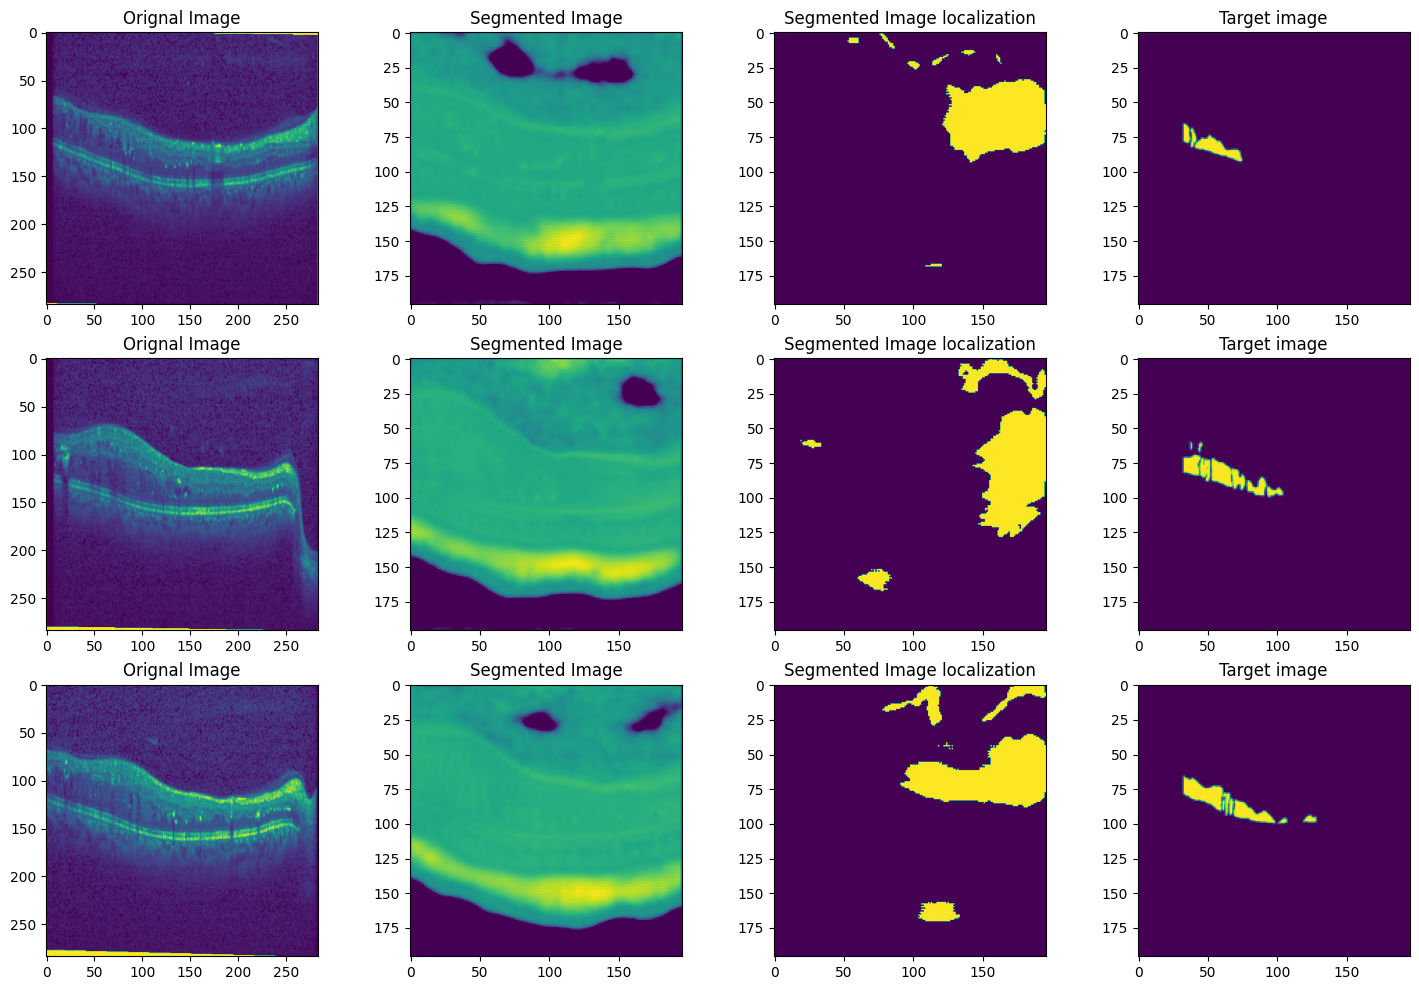

In [ ]:
plot_examples(x_val, y_val)